## Importing Libraries

In [1]:
import os
import cv2
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
from matplotlib.image import imread
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.metrics import fbeta_score, classification_report 
from os import listdir
import itertools
from collections import Counter
import random
import warnings
# filter warnings
warnings.filterwarnings('ignore')

2024-06-16 21:42:40.658012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 21:42:40.658121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 21:42:40.808247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading the dataset

In [2]:
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

### Loading the image and label datasets

In [3]:
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'
test_additional = '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'

In [4]:
train_labels = pd.read_csv(train_path)
train_labels.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
test_labels = pd.read_csv(test_path)
test_labels.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


## Exploratory Data Analysis

### Visualizing how many times each label appears in the dataset

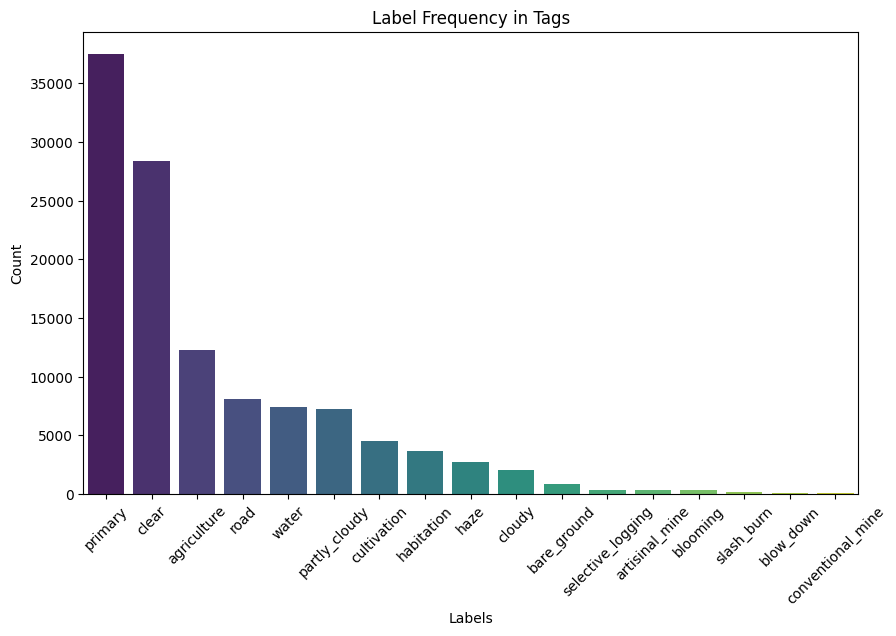

In [6]:
split_labels = [tag for tags in train_labels["tags"] for tag in tags.split(" ")]
# Counting the occurrences of each label
label_counts = Counter(split_labels)

# Converting the counter to a DataFrame for easier plotting
label_counts_df = pd.DataFrame.from_dict(label_counts, orient="index", columns=["count"])

# Sorting the DataFrame by count
label_counts_df = label_counts_df.sort_values(by="count", ascending=False)

# Step 4: Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts_df.index, y=label_counts_df["count"], palette='viridis')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Frequency in Tags")
plt.xticks(rotation=45)
plt.show()

### Visualizing the number of labels per image

In [7]:
# Splitting the tags and counting the number of tags for each image
train_labels['tag_count'] = train_labels["tags"].apply(lambda x: len(x.split(' ')))

# Creating a new DataFrame with the image_id and the count of tags
tag_count_df = train_labels[["image_name", "tag_count"]]
tag_count_df

,image_name,tag_count
0,train_0,2
1,train_1,4
2,train_2,2
3,train_3,2
4,train_4,5
...,...,...
40474,train_40474,2
40475,train_40475,1
40476,train_40476,3
40477,train_40477,4


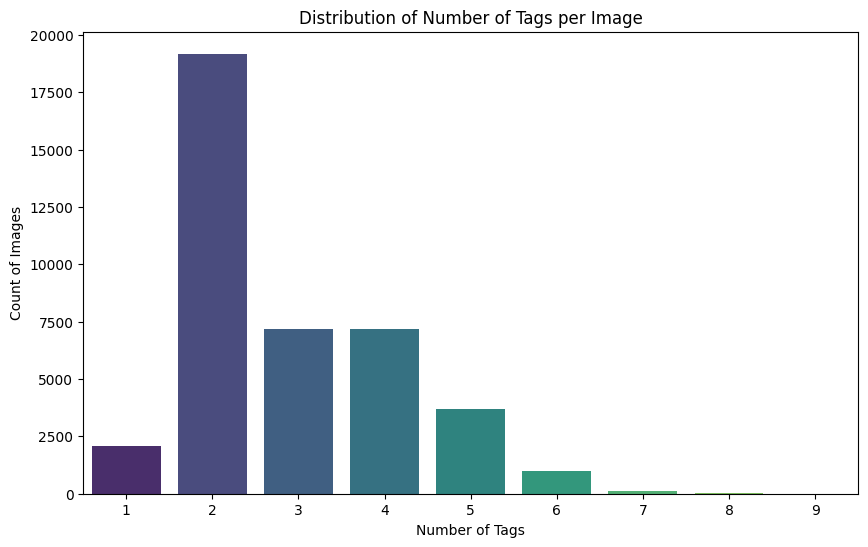

In [8]:
# Creating a count plot of the number of tags
plt.figure(figsize=(10, 6))
sns.countplot(x="tag_count", data=tag_count_df, palette='viridis')
plt.xlabel("Number of Tags")
plt.ylabel("Count of Images")
plt.title("Distribution of Number of Tags per Image")
plt.show()

### Viewing some images

In [9]:
# Adding the .jpg extension to the image labels for uniformity with the image names
train_labels["image_name"] = train_labels["image_name"].apply(lambda x: '{}.jpg'.format(x))
train_labels.head()

,image_name,tags,tag_count
0,train_0.jpg,haze primary,2
1,train_1.jpg,agriculture clear primary water,4
2,train_2.jpg,clear primary,2
3,train_3.jpg,clear primary,2
4,train_4.jpg,agriculture clear habitation primary road,5


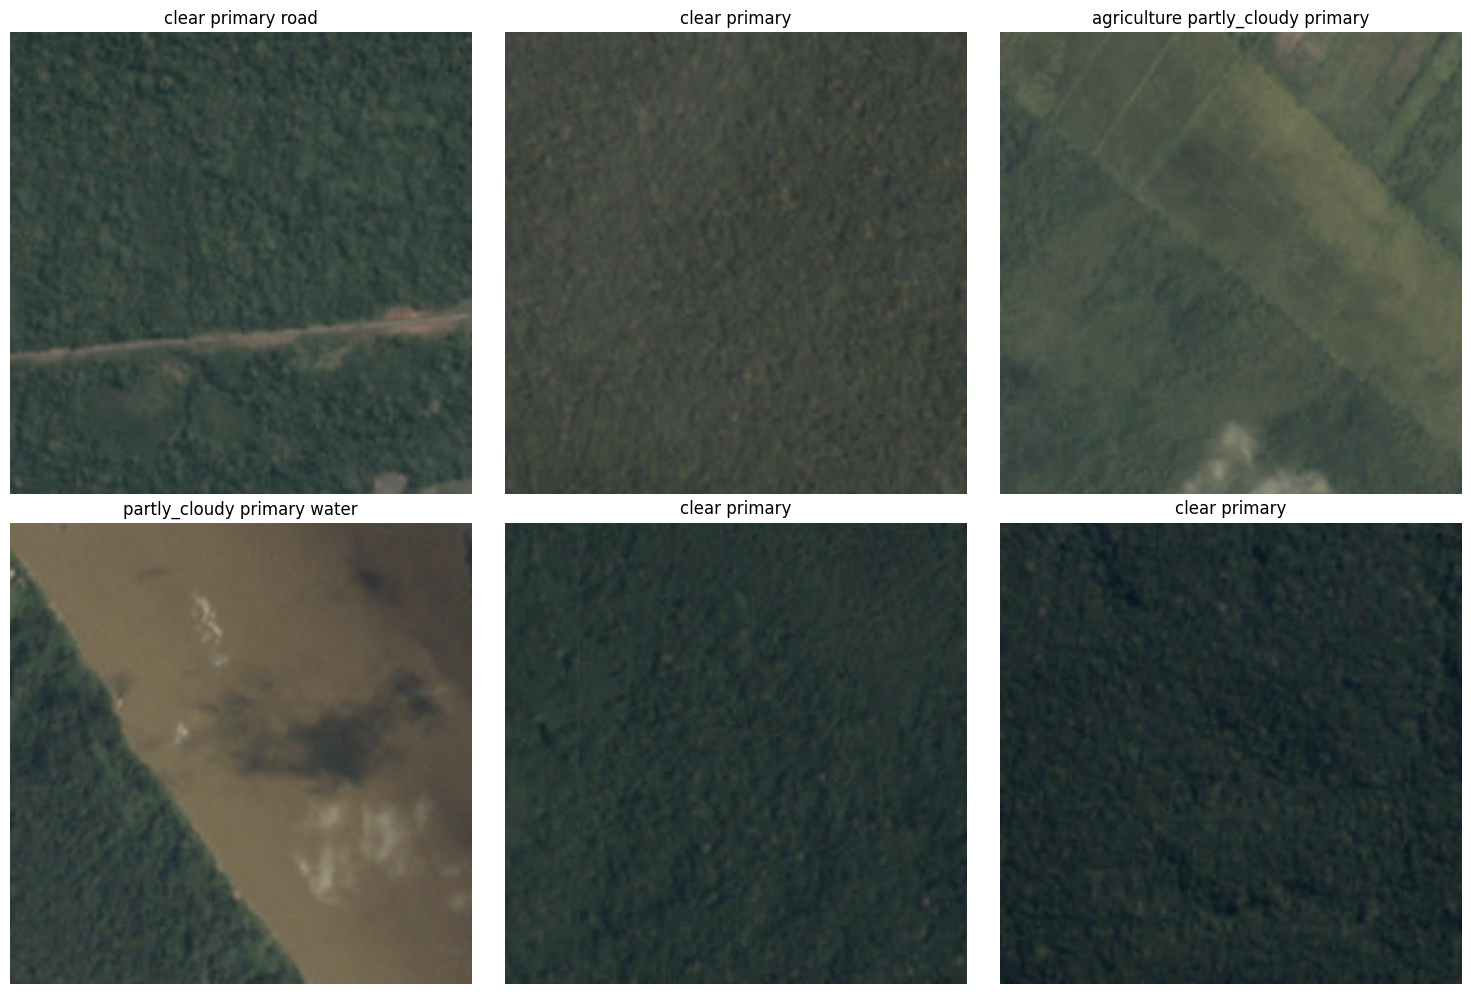

In [10]:
# Creating a dictionary to map image filenames to labels
labels_dict = pd.Series(train_labels.tags.values, index=train_labels.image_name).to_dict()

# Listing all image files in the directory
image_files = [os.path.join(train_images, f) for f in os.listdir(train_images)]

# Selecting 6 random images
random_images = random.sample(image_files, 6)

# Displaying the images with labels as titles
plt.figure(figsize=(15, 10))

for i, image_path in enumerate(random_images, start=1):
    image = imread(image_path)
    plt.subplot(2, 3, i) 
    plt.imshow(image)
    plt.axis('off')  

    # Extracting the image file name and get the corresponding label
    image_name = os.path.basename(image_path)
    label = labels_dict.get(image_name, "Unknown")

    plt.title(label)  # Set the label as the title
plt.tight_layout()
plt.show()

## Data Preprocessing

### Finding the number of unique labels in the dataset

In [11]:
# Extracting values and split each string into a list of words
split_labels2 = [tags.split(' ') for tags in train_labels["tags"].values]

# Flattening the list of lists into a single list
flattened_labels = list(itertools.chain.from_iterable(split_labels2))

# Getting the unique labels using set
unique_labels = list(set(flattened_labels))

unique_labels

['partly_cloudy',
 'blow_down',
 'agriculture',
 'conventional_mine',
 'habitation',
 'primary',
 'haze',
 'cloudy',
 'bare_ground',
 'cultivation',
 'road',
 'artisinal_mine',
 'water',
 'slash_burn',
 'blooming',
 'clear',
 'selective_logging']

In [12]:
n = len(unique_labels)
n

17

In [13]:
train_labels.head()

,image_name,tags,tag_count
0,train_0.jpg,haze primary,2
1,train_1.jpg,agriculture clear primary water,4
2,train_2.jpg,clear primary,2
3,train_3.jpg,clear primary,2
4,train_4.jpg,agriculture clear habitation primary road,5


## Feature Encoding

### Resizing the Training Images and One-Hot Encoding for the Image Tags

In [14]:
# train_path, train_labels
# Function to read and resize an image
def read_and_resize(image_path, size=(32, 32)):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, size)
    return resized_image

# Function to one-hot encode the image tags
def tags_to_one_hot(tags, label_map, num_classes=17):
    targets = np.zeros(num_classes)
    for tag in tags.split(" "):
        targets[label_map[tag]] = 1
    return targets

# Creating a dictionary to map each tag to an index
unique_tags = sorted(set(tag for tags in train_labels["tags"] for tag in tags.split(" ")))
label_map = {tag: idx for idx, tag in enumerate(unique_tags)}

# Preprocessing the images and labels
x_train = np.array(
    [read_and_resize(os.path.join(train_images, f"{img_id}")) for img_id in train_labels["image_name"]],
    dtype=np.float16
) / 255.0

y_train = np.array(
    [tags_to_one_hot(tags, label_map) for tags in train_labels["tags"]],
    dtype=np.uint8
)
# Printing the shape of the processed arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (40479, 32, 32, 3)
y_train shape: (40479, 17)


### Splitting the training data

In [15]:
#Splitting the training data into training and validation set

x_train2 = x_train[0:35000]
x_val = x_train[35000:]
y_train2 = y_train[0:35000]
y_val = y_train[35000:]

print("x_train2: {}".format(x_train2.shape)) 
print("x_val: {}".format(x_val.shape)) 
print("y_train2: {}".format(y_train2.shape)) 
print("y_val: {}".format(y_val.shape))

x_train2: (35000, 32, 32, 3)
x_val: (5479, 32, 32, 3)
y_train2: (35000, 17)
y_val: (5479, 17)


### Model Training

In [19]:
input_shape = (32, 32, 3)
num_classes = 17
# Defining the CNN model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3,3), input_shape= input_shape, activation="relu", kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output from the convolutional layers
model.add(Flatten())

# Fully connected layer 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='sigmoid')) 

In [20]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint('best_model.keras', save_best_only=True)]

In [21]:
# Training the model
history = model.fit(
    x_train2, y_train2,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
  71/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0968 - loss: 0.4293

I0000 00:00:1718574638.816146     162 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.0446 - loss: 0.2650 - val_accuracy: 0.0214 - val_loss: 0.1796
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0511 - loss: 0.1816 - val_accuracy: 0.0476 - val_loss: 0.1599
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0815 - loss: 0.1662 - val_accuracy: 0.0641 - val_loss: 0.1513
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1009 - loss: 0.1580 - val_accuracy: 0.0517 - val_loss: 0.1518
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1052 - loss: 0.1540 - val_accuracy: 0.0522 - val_loss: 0.1434
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1012 - loss: 0.1498 - val_accuracy: 0.0697 - val_loss: 0.1392
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0999 - loss: 0.1442 - val_accuracy: 0.0535 - val_loss: 0.1386
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0964 - loss: 0.1405 - val_accura

In [22]:
# Evaluating the model on the validation set
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0817 - loss: 0.1341
Validation Loss: 0.13107901811599731
Validation Accuracy: 0.08176674693822861


In [23]:
# Making predictions and generating a classification report
y_val_pred = (model.predict(x_val) > 0.5).astype("int32")
print(classification_report(y_val, y_val_pred))
print(fbeta_score(y_val, np.array(y_val_pred) > 0.2, beta=2, average='samples'))

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1693
           1       0.80      0.33      0.46        49
           2       0.00      0.00      0.00       135
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        13
           5       0.94      0.97      0.96      3865
           6       0.82      0.65      0.73       259
           7       0.00      0.00      0.00         8
           8       0.60      0.12      0.20       623
           9       0.65      0.30      0.41       480
          10       0.79      0.52      0.63       360
          11       0.91      0.85      0.88       995
          12       0.97      0.99      0.98      5100
          13       0.67      0.66      0.67      1085
          14       0.00      0.00      0.00        45
          15       0.00      0.00      0.00        38
          16       0.76      0.27      0

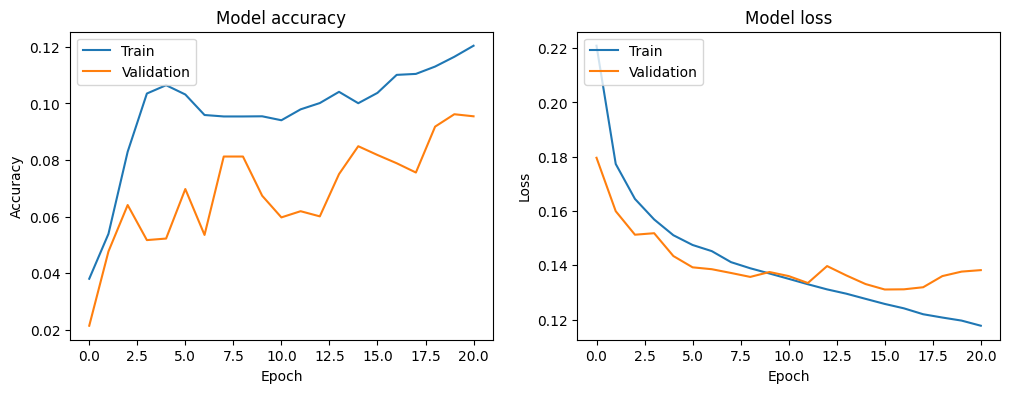

In [24]:
# Plotting the training history

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Model Testing

### Merging the two test sets

In [25]:
test_dir1 = test_images
test_dir2 = test_additional
# Function to load and preprocess the test images
def load_and_preprocess_images(directory, target_size=(32, 32)):
    image_list = []
    filenames = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            # Loading the image
            img = cv2.imread(file_path)
            # Resizing the image to the target size
            img = cv2.resize(img, target_size)
            # Normalizing the image (optional, depending on your model's requirements)
            img = img.astype('float32') / 255.0
            # Appending to the list
            image_list.append(img)
            filenames.append(filename)
    # Converting list to a numpy array
    return np.array(image_list), filenames

In [26]:
# Loading images from both test directories
test_images1, filenames1 = load_and_preprocess_images(test_dir1)
test_images2, filenames2 = load_and_preprocess_images(test_dir2)

In [27]:
# Combining the image arrays and filenames
comb_test_images = np.concatenate((test_images1, test_images2), axis=0)
comb_filenames = filenames1 + filenames2

# Verifying the shapes and lengths
print(f"Shape of combined test images: {comb_test_images.shape}")
print(f"Number of combined filenames: {len(comb_filenames)}")

Shape of combined test images: (61191, 32, 32, 3)
Number of combined filenames: 61191


In [28]:
y_test_pred = model.predict(comb_test_images)
threshold = 0.6  
y_test_pred_binary = (y_test_pred > threshold).astype(int)

# Map predictions back to the label names
#unique_tags = sorted(set(tag for tags in train_df['tags'] for tag in tags.split(' ')))
predicted_labels = []

for preds in y_test_pred_binary:
    tags = [unique_tags[i] for i, pred in enumerate(preds) if pred == 1]
    predicted_labels.append(' '.join(tags))

1913/1913 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


### Creating a Submission Dataset

In [29]:
sub = pd.read_csv(test_path)
sub.drop('tags', axis = 1)
sub['tags'] = predicted_labels
sub.to_csv('submission3.csv', index = False)

In [30]:
submission = pd.read_csv("submission3.csv")
submission.head()

,image_name,tags
0,test_0,agriculture clear primary
1,test_1,primary
2,test_2,agriculture clear cultivation primary
3,test_3,agriculture clear primary road
4,test_4,clear primary
